In [1]:
import os, glob, re, sys
import socket
import torch
import wandb
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import pandas as pd
import umap
from sklearn.manifold import TSNE
from tqdm import tqdm_notebook

sys.path.append('../')
from src.vae_models import *
from src.datasets import Astro_lightcurves
from src.utils import *

import warnings
warnings.filterwarnings('ignore')

main_path = os.path.dirname(os.getcwd())

save_plots = False
save_tables = False

In [2]:
ID = 'yp4qdw1r'
gpu = False

rnd_seed = 13
np.random.seed(rnd_seed)
torch.manual_seed(rnd_seed)
torch.cuda.manual_seed_all(rnd_seed)

In [3]:
if not os.path.exists('%s/wandb/run--%s/VAE_model_None.pt' % 
                      (main_path, ID)):
    print('Downloading files from Weight & Biases')
    
    api = wandb.Api()
    run = api.run('jorgemarpa/Phy-VAE/%s' % (ID))
    run.file('VAE_model_None.pt').download(replace=True, 
                                           root='%s/wandb/run--%s/' % 
                                           (main_path, ID))
    run.file('config.yaml').download(replace=True, 
                                     root='%s/wandb/run--%s/' % 
                                     (main_path, ID))

device = torch.device("cuda:0" if torch.cuda.is_available() and gpu else "cpu")

## Load model variables into VAE model

In [4]:
vae, config = load_model_list(ID=ID)
config

Loading from... 
 /home/jorgemarpa/Astro/PELS-VAE/wandb/run--yp4qdw1r/VAE_model_None.pt
Is model in cuda?  False


{'architecture': 'tcn',
 'batch_size': 128,
 'beta_vae': '0.75',
 'classes': 'all',
 'data': 'OGLE3',
 'dropout': 0.2,
 'epochs': 150,
 'feed_pp': 'F',
 'hidden_size': 48,
 'kernel_size': 5,
 'label_dim': 8,
 'latent_dim': 4,
 'latent_mode': 'repeat',
 'learning_rate': 0.001,
 'learning_rate_scheduler': 'cos',
 'n_feats': 3,
 'n_train_params': 300945,
 'num_layers': 9,
 'phys_params': 'PTA',
 'physics_dim': 3,
 'sequence_lenght': 600,
 'transpose': False,
 'normed': True,
 'folded': True,
 'date': '',
 'ID': 'yp4qdw1r'}

In [5]:
dataset = Astro_lightcurves(survey=config['data'],
                            band='I' if config['data'] else 'B',
                            use_time=True,
                            use_err=True,
                            norm=config['normed'],
                            folded=config['folded'],
                            machine=socket.gethostname(),
                            seq_len=config['sequence_lenght'],
                            phy_params=config['phys_params'])

if config['classes'].split('_')[0] == 'drop':
    dataset.drop_class(config['classes'].split('_')[1])
elif config['classes'].split('_')[0] == 'only':
    dataset.only_class(config['classes'].split('_')[1])
print('Using physical parameters: ', dataset.phy_names)
dataset.remove_nan()
print(dataset.class_value_counts())
print('Total: ', len(dataset))
num_cls = dataset.labels_onehot.shape[1]

train_load, test_load = dataset.get_dataloader(batch_size=config['batch_size'],
                                               shuffle=True,
                                               test_split=.2,
                                               random_seed=rnd_seed)

Loading from:
 /home/jorgemarpa/data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600.npy.gz
Using physical parameters:  ['Period', 'teff_val', 'abs_Gmag']
ECL      8817
ELL      8637
LPV      8201
CEP      6906
T2CEP    3734
DSCT     3704
RRLYR    2962
ACEP       70
Name: Type, dtype: int64
None
Total:  43031


In [6]:
mu, std = evaluate_encoder(vae, test_load, config, 
                           n_classes=num_cls, force=True)

Evaluating Encoder...



Elapsed time  : 709.00 s
########################################


In [7]:
test_meta = dataset.meta.iloc[test_load.sampler.indices]
test_lcs = dataset.lcs[test_load.sampler.indices]
mu.shape, std.shape, test_meta.shape, test_lcs.shape

((8606, 5), (8606, 5), (8606, 30), (8606, 600, 3))

In [26]:
test_meta.loc[:,dataset.phy_aux].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8606 entries, 36682 to 40726
Data columns (total 3 columns):
Period      8606 non-null float32
teff_val    8606 non-null float32
abs_Gmag    8606 non-null float32
dtypes: float32(3)
memory usage: 488.1 KB


# Plot LC reconstruction

# Joint distributions of latent variables

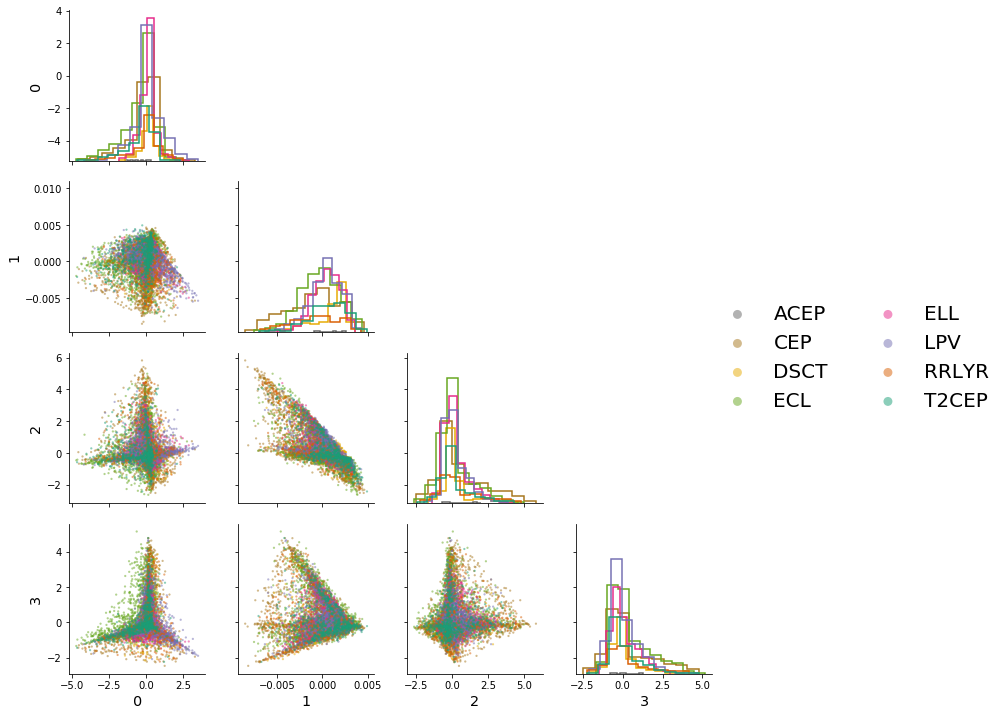

In [8]:
g = sb.PairGrid(mu, 
                hue='class', hue_order=sorted(set(mu.loc[:,'class'].values)),
                despine=True, palette='Dark2_r')
g = g.map_diag(plt.hist, histtype='step', lw=1.5)
g = g.map_offdiag(plt.scatter, marker='.', s=20, alpha=.5, edgecolors='none')
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
g = g.add_legend(fontsize=20, title='', 
                 markerscale=4, ncol=2)    
for ax in g.axes.flat:
    # This only works for the left ylabels
    ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')
    ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')

if save_plots:
    plt.savefig('%s/imgs/z_pairplot_%s.pdf' % (path,ID), 
            format='pdf', bbox_inches='tight')
    
plt.show()

### tSNE projection to 2D

In [ ]:
mu_to_tsne = mu.copy()
meta_to_tsne = test_meta.copy()
print(meta_to_tsne.Type.value_counts())

#for perplex in [2,5,8,10,15,20,25,30,40,50,100]:
tsne = TSNE(n_components=2, perplexity=40, 
            random_state=10, verbose=0)
mu_embed = tsne.fit_transform(mu_to_tsne.iloc[:,:-1].values)
print('Embeding shape: ', mu_embed.shape)

In [ ]:
meta_to_tsne.info()

In [ ]:
scatter_hue(mu_embed[:,0], mu_embed[:,1], 
            mu_to_tsne.loc[:,'class'].values,
            disc=True)
scatter_hue(mu_embed[:,0], mu_embed[:,1], 
            np.log10(meta_to_tsne.loc[:,'teff_val'].values),
            disc=False, c_label=r'$T_{eff}$')
scatter_hue(mu_embed[:,0], mu_embed[:,1], 
            meta_to_tsne.loc[:,'bp_rp'].values,
            disc=False, c_label='bp-rp')
scatter_hue(mu_embed[:,0], mu_embed[:,1], 
            meta_to_tsne.loc[:,'abs_Gmag'].values,
            disc=False, c_label=r'$M_g$')
scatter_hue(mu_embed[:,0], mu_embed[:,1], 
            np.log10(meta_to_tsne.loc[:,'Period'].values),
            disc=False, c_label='log(P)')
scatter_hue(mu_embed[:,0], mu_embed[:,1], 
            meta_to_tsne.loc[:,'[Fe/H]_J95'].values,
            disc=False, c_label='[Fe/H]_J95')

## UMAP projection

In [ ]:
umapper = umap.UMAP(n_neighbors=100, min_dist=0.05, 
                    n_components=2, metric='euclidean')
embedding = umapper.fit_transform(mu_to_tsne.iloc[:,:-1].values)

In [ ]:
scatter_hue(embedding[:,0], embedding[:,1], 
            meta_to_tsne.loc[:,'Type'].values,
            disc=True)
scatter_hue(embedding[:,0], embedding[:,1], 
            meta_to_tsne.loc[:,'bp_rp'].values,
            disc=False, c_label='bp-rp')
scatter_hue(embedding[:,0], embedding[:,1], 
            meta_to_tsne.loc[:,'abs_Gmag'].values,
            disc=False, c_label=r'$M_g$')
scatter_hue(embedding[:,0], embedding[:,1], 
            np.log10(meta_to_tsne.loc[:,'Period'].values),
            disc=False, c_label='log(P)')
scatter_hue(embedding[:,0], embedding[:,1], 
            meta_to_tsne.loc[:,'[Fe/H]_J95'].values,
            disc=False, c_label='[Fe/H]_J95')

# Evaluate VAE with dT

In [74]:
N_resamp = 10
new_onehot = torch.from_numpy(dataset[test_load.sampler.indices][-2]).to('cuda:0')
new_lcs_t = torch.from_numpy(test_lcs).to('cuda:0')
vae = vae.to('cuda:0')
test_meta.teff_e.fillna(test_meta.teff_e.median(), inplace=True)
new_latent, new_xhat = [], []
new_test_meta = []
chunks = list(range(0, test_lcs.shape[0], 100))
chunks[-1] = test_lcs.shape[0]

for k in range(N_resamp):
    new_meta = test_meta.copy()
    new_meta.teff_val = np.random.normal(loc=test_meta.teff_val, 
                                         scale=test_meta.teff_e/2)
    new_test_meta.append(new_meta)
    new_meta_pp = torch.from_numpy(dataset.mm_scaler.transform(new_meta.loc[:, dataset.phy_aux].values.astype(np.float32))).to('cuda:0')
    print(new_lcs_t.shape, new_meta_pp.shape, new_onehot.shape)

    aux_mu, aux_std, aux_xhat = [], [], []
    
    with tqdm_notebook(total=len(chunks)-1) as pbar: 
        for kk in range(len(chunks)-1):
            if config['label_dim'] > 0 and config['physics_dim'] > 0:
                xhat, mu_, logvar_, z_ = vae(new_lcs_t[chunks[kk]:chunks[kk+1]], label=new_onehot[chunks[kk]:chunks[kk+1]], phy=new_meta_pp[chunks[kk]:chunks[kk+1]])
            elif config['label_dim'] > 0 and config['physics_dim'] == 0:
                xhat, mu_, logvar_, z_ = vae(new_lcs_t[chunks[kk]:chunks[kk+1]], label=new_onehot[chunks[kk]:chunks[kk+1]])
            elif config['label_dim'] == 0:
                xhat, mu_, logvar_, z_ = vae(new_lcs_t[chunks[kk]:chunks[kk+1]])
                
            aux_mu.extend(mu_.data.cpu().numpy())
            aux_std.extend(logvar_.data.cpu().numpy())
            aux_std.append(xhat.data.cpu().numpy())
            pbar.update()
    aux_mu = np.array(aux_mu)
    aux_std = np.exp(0.5 * np.array(aux_std))
    new_latent.append([aux_mu, aux_std])
    
    break

torch.Size([8606, 600, 3]) torch.Size([8606, 3]) torch.Size([8606, 8])


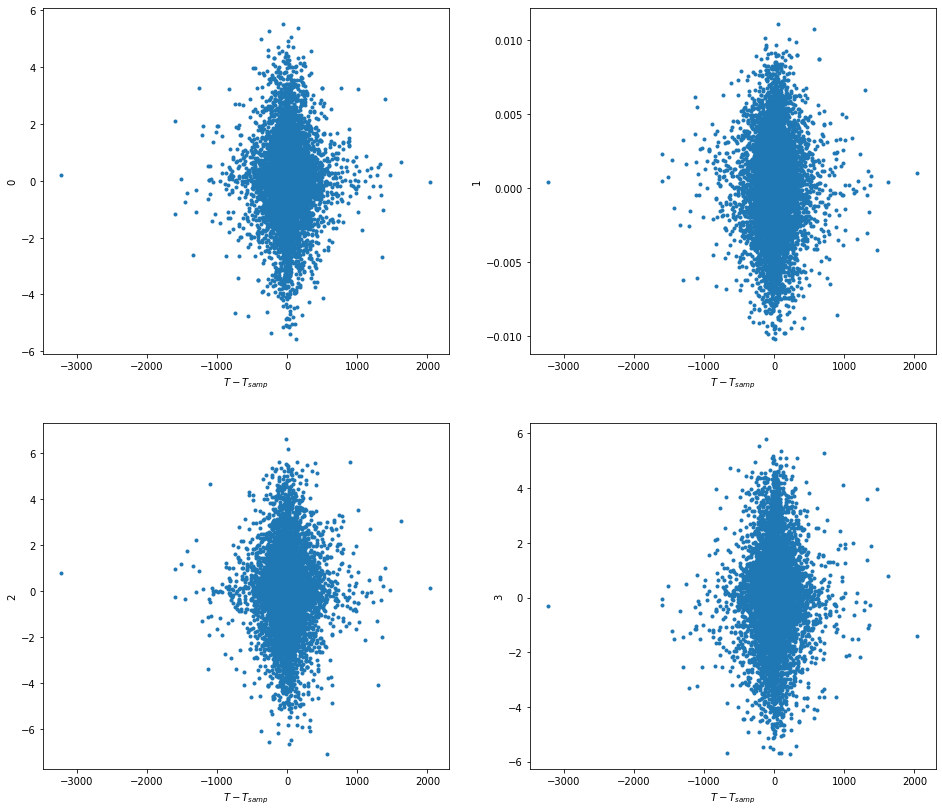

In [75]:
for k in range(N_resamp):
    fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(16,14),)
    for i, ax in enumerate(axis.ravel()):
        ax.plot(test_meta.teff_val.values - new_test_meta[k].teff_val.values,
                mu.iloc[:, i].values - new_latent[k][0][:, i], '.')
        ax.set_xlabel(r'$T - T_{samp}$')
        ax.set_ylabel(i)
    
    plt.show()
    break

In [85]:
dataset.meta.subType.value_counts()

ELL           8637
Mira          8201
F             5011
NC            4300
1O            2639
RRab          2042
WVir          1476
ED            1259
RVTau         1060
rad+nrad      1056
BLHer          940
C              914
RRc            899
EC             888
nonEC          862
SINGLEMODE     713
F/1O           677
ESD            489
pWVir          258
F/1O+nr        242
1O/2O/3O       122
F/2O           119
1O/2O          100
ED_VAR          50
ED_ESD          21
RRd             19
ELL_EC          17
ED_TEB           6
ESD_DPV          6
RRe              2
EC+ED            2
ED+EC            1
1O/X             1
ED+ED            1
ELL+ESD          1
Name: subType, dtype: int64

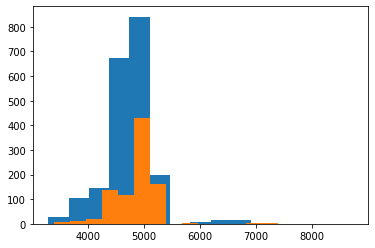

In [89]:
plt.hist(dataset.meta.query('subType == "RRab"').teff_val, bins=15)
plt.hist(dataset.meta.query('subType == "RRc"').teff_val, bins=15)
plt.show()

(array([ 82., 266., 403., 200., 141.,  69.,  42.,  29.,  47., 161.]),
 array([  61.833252 ,  195.1999268,  328.5666016,  461.9332764,
         595.2999512,  728.666626 ,  862.0333008,  995.3999756,
        1128.7666504, 1262.1333252, 1395.5      ]),
 <a list of 10 Patch objects>)

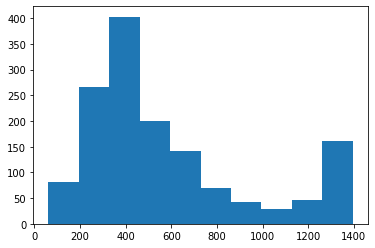

In [90]:
plt.hist(dataset.meta.query('Type == "RRLYR"').teff_e)